Before starting the mining process, please download the corpus from https://www.cs.cmu.edu/~jwieting/  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fn = '/content/drive/MyDrive/para-nmt-50m.txt'

In [ ]:
import pandas as pd
import numpy as np
import csv
pd.options.display.max_colwidth = 150

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [ ]:
df = pd.read_csv(fn, sep='\t', header=None, nrows=1_000_000, encoding='utf-8', quoting=csv.QUOTE_NONE).dropna()
df.columns = ['reference', 'translation', 'similarity']

In [ ]:
def lenth_diff(row):
    l1 = len(row.reference)
    l2 = len(row.translation)
    return np.abs(l1-l2) / (max(l1, l2) + 1)

df['lenght_diff'] = df.apply(lenth_diff, axis=1)

In [ ]:
print(np.mean((df.similarity > 0.6)))
print(np.mean(df.similarity <= 0.95))
print(np.mean(df.lenght_diff <= 0.4))
print(np.mean((df.similarity > 0.6) & (df.similarity <= 0.95) & (df.lenght_diff <= 0.4)))

0.7133121399364198
0.8754666263998792
0.8481745445236336
0.5371926115778347


In [ ]:
nonsim = df[(df.similarity > 0.6) & (df.similarity <= 0.95) & (df.lenght_diff <= 0.4)].head(1000)
nonsim.shape

(1000, 4)

In [ ]:
from tqdm.auto import tqdm, trange
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

In [ ]:
model_name = 'SkolkovoInstitute/roberta_toxicity_classifier_v1'

tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

def classify_preds(preds, batch_size=32, soft=True, threshold=0.5):
    single = False
    if isinstance(preds, str):
        preds = [preds]
        single = True
    results = []

    for i in trange(0, len(preds), batch_size):
        batch = tokenizer(preds[i:i + batch_size], return_tensors='pt', padding=True)
        with torch.no_grad():
            logits = model(**batch).logits
        if soft:
            result = torch.softmax(logits, -1)[:, 1].cpu().numpy()
        else:
            result = (logits[:, 1] > threshold).cpu().numpy()
        results.extend([1 - item for item in result])
    if single:
        return np.mean(results)
    return results

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/530 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier_v1 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
nonsim['ref_tox'] = classify_preds(nonsim.reference.tolist(), batch_size=64)
nonsim['trn_tox'] = classify_preds(nonsim.translation.tolist(), batch_size=64)


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

<Axes: >

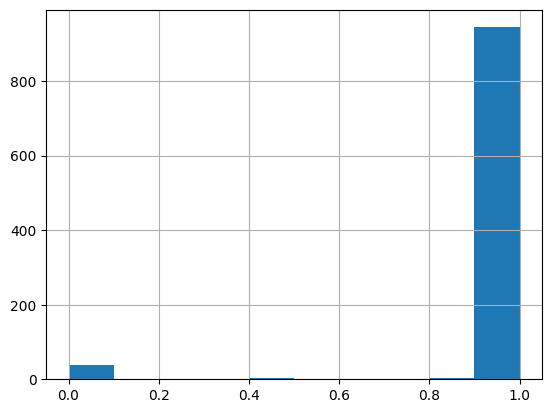

In [ ]:
nonsim.trn_tox.hist()

* We filter sentences with moderate similarity (60% to 95%) and similar length (no more then 40% difference) - 50%% of corpus
* Out of them, 2% have estimated toxicity is very different between the source and the translation (20 out of 1000)
* Out of these 18:
    * 2 are false paraphrases
    * 8 in fact have comparable toxicity
    * 10 are valid detoxifications

In [ ]:
fltr = np.abs(nonsim.trn_tox-nonsim.ref_tox) > 0.5
print(np.mean(fltr))
print(np.sum(fltr))

0.02
20


In [ ]:
pd.options.display.max_colwidth = 500

In [ ]:
nonsim[fltr].reset_index(drop=True)

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, that explains the high level of neurotransmitters.","if Alkar floods her with her mental waste, it would explain the high levels of neurotransmitter.",0.785171,0.010309,0.985805,0.018017
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.934527,0.000961
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.786678,0.014932
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.946637,0.005785
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.990598,0.000652
5,I'm not gonna have a child... ...with the same genetic disorder as me who's gonna die. L...,I'm not going to breed kids with a genetic disorder that makes them die.,0.703185,0.206522,0.049044,0.964154
6,"They're all laughing at us, so we'll kick your ass.",they're laughing at us. We'll show you.,0.618866,0.230769,0.000508,0.999869
7,Maine was very short on black people back then.,there wasn't much black in Maine then.,0.720482,0.187500,0.036320,0.851292
8,"Briggs, what the hell's happening?","Briggs, what the hell is going on?",0.920373,0.000000,0.840904,0.158931
9,"Another one simply had no clue what to do, so whenever he met my brother he'd beat the crap out of him, and then say:","another simply didn't know what to do, so whenever he met my brother, he nearly beat the shit out of him.",0.877540,0.101695,0.944629,0.069529


# Large scale fine tuning

In [ ]:
chunksize = 3_000

In [ ]:
df = pd.read_csv(fn, sep='\t', header=None, nrows=1_000_000, encoding='utf-8', quoting=csv.QUOTE_NONE).dropna()
df.columns = ['reference', 'translation', 'similarity']

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



* 50M / 3K = 16K iterations
* with 1 minute/iteration, the job will take 11 days, but with free GPUs this is faster

In [ ]:
results = []

for i, chunk in enumerate(tqdm(pd.read_csv(fn, sep='\t', header=None, encoding='utf-8', quoting=csv.QUOTE_NONE, chunksize=chunksize))):
    chunk.dropna(inplace=True)
    chunk.columns = ['reference', 'translation', 'similarity']
    chunk['lenght_diff'] = chunk.apply(lenth_diff, axis=1)
    nonsim = chunk[(chunk.similarity > 0.6) & (chunk.similarity <= 0.95) & (chunk.lenght_diff <= 0.4)].copy()

    nonsim['ref_tox'] = classify_preds(nonsim.reference.tolist(), batch_size=64)
    nonsim['trn_tox'] = classify_preds(nonsim.translation.tolist(), batch_size=64)

    fltr = np.abs(nonsim.trn_tox-nonsim.ref_tox) > 0.5
    mined = nonsim[fltr]
    results.append(mined)
    # print(nonsim.shape[0], mined.shape[0])
    if i > 0 and i % 10 == 0:
        res_df = pd.concat(results, ignore_index=True)
        print(res_df.shape[0], 'samples')
        res_df.to_csv('filtered.tsv', sep='\t', encoding='utf-8')


0it [00:00, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
res_df = pd.concat(results, ignore_index=True)
res_df.shape

ValueError: No objects to concatenate

In [ ]:
res_df.describe()

NameError: name 'res_df' is not defined

In [ ]:
res_df.sample(10)

NameError: name 'res_df' is not defined

In [ ]:
res_df['tox_diff'] = np.abs(res_df.ref_tox - res_df.trn_tox)
res_df.tox_diff.hist()

NameError: name 'res_df' is not defined